# Cleanup & Preprocess - Ngrams

---

*Features*

- The **DocumentToBigramCounterTransformer** class is generalized into a **DocumentToNgramCounterTransformer** class. 
- Develop a `gridsearch_ngrams` function to grid search varying ngrams and vocabulary sizes.

*Improvements*

- still using baseline Naive Bayes and Logistic Regression classifiers so the gridsearch is inexpensive
- could implement early stopping techniques for complex models: compare max accuracies across loops, etc.

*Results*

- Confirm Tfidf representations do not do as well as BoW representations - as observed in the previous notebook's results.
- A bag-of-upto-trigrams with 2,000 terms reaches $\approx98.6\%$ mean accuracy.


### Setup

In [1]:
import os
import time
import json

import numpy as np
import pandas as pd

from datetime import datetime

start_time = time.time()
dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2020-12-19


### Load Data

In [2]:
def load_data(data):
    raw_path = os.path.join("data","1_raw")
    filename = ''.join([data, ".csv"])
    out_dfm = pd.read_csv(os.path.join(raw_path, filename))
    out_arr = np.array(out_dfm.iloc[:,0].ravel())
    return out_arr

X_train = load_data("X_train")
y_train = load_data("y_train")

### Cleanup $\longrightarrow$ Preprocessing $\longrightarrow$ Baseline Models

In [3]:
import urlextract
from nltk.stem import WordNetLemmatizer

import custom.clean_preprocess as cp

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

with open("contractions_map.json") as f:
    contractions_map = json.load(f)

url_extractor = urlextract.URLExtract()
lemmatizer = WordNetLemmatizer()

def gridsearch_ngrams(X_array, y_array, n_grams, vocab_sizes, 
                      cv=10, scoring='accuracy', n_jobs=-1, verbose=1):
    """Grid search:
           - for a given n_gram value, varying vocab_sizes 
           - uses bag-of-words (BoW) and Tfidf representations
           - uses baseline Naive Bayes and Logistic Regression models
           - performs cross validation
           - returns a dataframe with mean accuracies, fit times, and modeling times
       Defaults:
           - 10-fold CV
           - evaluates on accuracy
           - uses all available logical cores
           - verbose=1 prints best accuracies, as they are found
    """
    T1 = time.time()
    
    # instantiate lists
    bow_fit_times, tfidf_fit_times, bow_mod_times, tfidf_mod_times = [], [], [], []
    NB_bow_means, LR_bow_means, NB_tfidf_means, LR_tfidf_means = [], [], [], []
    
    for vocab_size in vocab_sizes:            
        pipe = Pipeline([('counter', cp.DocumentToNgramCounterTransformer(n_grams=n_grams)),
                         ('bow', cp.WordCounterToVectorTransformer(vocabulary_size=vocab_size)),
                         ('tfidf', TfidfTransformer())])
        # BoW fit
        bow_fit_start = time.time()
        X_counter = pipe['counter'].fit_transform(X_array)
        X_bow = pipe['bow'].fit_transform(X_counter)
        bow_fit_times.append(round(time.time() - bow_fit_start, 1))
        
        # Tfidf fit
        tfidf_fit_start = time.time()
        X_tfidf = pipe['tfidf'].fit_transform(X_bow)
        tfidf_fit_times.append(round(time.time() - tfidf_fit_start, 1))
        
        # instantiate models
        NB_clf = MultinomialNB()
        log_clf = LogisticRegression(solver="liblinear", random_state=42) 
        
        # BoW modeling
        bow_mod_start = time.time()
        bow_NBscores = cross_val_score(NB_clf, X_bow, y_array, 
                                       cv=cv, verbose=0, scoring=scoring, n_jobs=n_jobs)
        bow_LRscores = cross_val_score(log_clf, X_bow, y_array, 
                                       cv=cv, verbose=0, scoring=scoring, n_jobs=n_jobs)   
        NB_bow_means.append(round(bow_NBscores.mean(), 4))
        LR_bow_means.append(round(bow_LRscores.mean(), 4))
        bow_mod_times.append(round(time.time() - bow_mod_start, 1))
        
        # Tfidf modeling
        tfidf_mod_start = time.time()
        tfidf_NBscores = cross_val_score(NB_clf, X_tfidf, y_array,
                                         cv=cv, verbose=0, scoring=scoring, n_jobs=n_jobs)                         
        tfidf_LRscores = cross_val_score(log_clf, X_tfidf, y_array,
                                         cv=cv, verbose=0, scoring=scoring, n_jobs=n_jobs)
        NB_tfidf_means.append(round(tfidf_NBscores.mean(), 4))
        LR_tfidf_means.append(round(tfidf_LRscores.mean(), 4))
        tfidf_mod_times.append(round(time.time() - tfidf_mod_start, 1))
        
        # print best accuracies as they're found
        if verbose == 1:
            sec_ = time.time() - bow_fit_start
            max_ = max(bow_NBscores.mean(), bow_LRscores.mean(),
                       tfidf_NBscores.mean(), tfidf_LRscores.mean())
            if max_ > max(max(NB_bow_means), max(LR_bow_means),
                          max(NB_tfidf_means), max(LR_tfidf_means)):
                print(f'vocab size: {vocab_size:0.0f} | loop time: {sec_:0.0f}s | max accuracy: {max_:0.4f}')
    
    # return data frame with results
    df = pd.DataFrame({"ngram":n_grams,
                       "vocab_size":vocab_sizes,
                       "bow_fit_time":bow_fit_times,
                       "tfidf_fit_time":tfidf_fit_times,
                       "bow_mod_time":bow_mod_times,
                       "tfidf_mod_time":tfidf_mod_times,
                       "NB_bow_means":NB_bow_means,
                       "LR_bow_means":LR_bow_means,
                       "NB_tfidf_means":NB_tfidf_means,
                       "LR_tfidf_means":LR_tfidf_means
                      })

    mins, secs = divmod(time.time() - T1, 60)
    print(f'Elapsed: {mins:0.0f} m {secs:0.0f} s')
    return df

In [4]:
vocab_sizes = list(range(100, 5100, 100))

unigram_df = gridsearch_ngrams(X_train, y_train, n_grams=1, vocab_sizes=vocab_sizes, cv=5)

vocab size: 100 | loop time: 8s | max accuracy: 0.9738
vocab size: 200 | loop time: 3s | max accuracy: 0.9782
vocab size: 400 | loop time: 3s | max accuracy: 0.9810
vocab size: 1000 | loop time: 3s | max accuracy: 0.9833
vocab size: 1400 | loop time: 3s | max accuracy: 0.9838
vocab size: 1500 | loop time: 3s | max accuracy: 0.9846
vocab size: 1600 | loop time: 3s | max accuracy: 0.9846
vocab size: 1800 | loop time: 3s | max accuracy: 0.9846
vocab size: 2000 | loop time: 3s | max accuracy: 0.9846
vocab size: 2100 | loop time: 3s | max accuracy: 0.9846
vocab size: 2200 | loop time: 3s | max accuracy: 0.9846
vocab size: 3600 | loop time: 3s | max accuracy: 0.9846
vocab size: 4300 | loop time: 3s | max accuracy: 0.9846
Elapsed: 2 m 33 s


In [5]:
bigram_df = gridsearch_ngrams(X_train, y_train, n_grams=2, vocab_sizes=vocab_sizes, cv=5)

vocab size: 100 | loop time: 4s | max accuracy: 0.9769
vocab size: 200 | loop time: 4s | max accuracy: 0.9787
vocab size: 300 | loop time: 4s | max accuracy: 0.9810
vocab size: 500 | loop time: 4s | max accuracy: 0.9828
vocab size: 1800 | loop time: 4s | max accuracy: 0.9851
vocab size: 1900 | loop time: 4s | max accuracy: 0.9851
vocab size: 2000 | loop time: 4s | max accuracy: 0.9851
Elapsed: 3 m 41 s


In [6]:
trigram_df = gridsearch_ngrams(X_train, y_train, n_grams=3, vocab_sizes=vocab_sizes)

vocab size: 100 | loop time: 7s | max accuracy: 0.9769
vocab size: 200 | loop time: 6s | max accuracy: 0.9823
vocab size: 300 | loop time: 6s | max accuracy: 0.9823
vocab size: 400 | loop time: 6s | max accuracy: 0.9841
vocab size: 700 | loop time: 6s | max accuracy: 0.9851
Elapsed: 4 m 60 s


In [7]:
quadrigram_df = gridsearch_ngrams(X_train, y_train, n_grams=4, vocab_sizes=vocab_sizes)

vocab size: 100 | loop time: 7s | max accuracy: 0.9769
vocab size: 200 | loop time: 7s | max accuracy: 0.9823
vocab size: 400 | loop time: 7s | max accuracy: 0.9841
vocab size: 900 | loop time: 8s | max accuracy: 0.9851
vocab size: 1000 | loop time: 7s | max accuracy: 0.9851
vocab size: 1300 | loop time: 7s | max accuracy: 0.9851
vocab size: 1400 | loop time: 8s | max accuracy: 0.9851
vocab size: 1500 | loop time: 7s | max accuracy: 0.9851
vocab size: 1600 | loop time: 7s | max accuracy: 0.9851
vocab size: 1700 | loop time: 7s | max accuracy: 0.9851
vocab size: 2300 | loop time: 8s | max accuracy: 0.9856
vocab size: 2400 | loop time: 7s | max accuracy: 0.9856
vocab size: 2500 | loop time: 7s | max accuracy: 0.9856
vocab size: 2600 | loop time: 7s | max accuracy: 0.9856
vocab size: 4000 | loop time: 7s | max accuracy: 0.9856
Elapsed: 6 m 6 s


In [8]:
master_df = pd.concat([unigram_df, 
                       bigram_df, 
                       trigram_df, 
                       quadrigram_df])

master_df.index = range(len(master_df))
master_df.head()

,ngram,vocab_size,bow_fit_time,tfidf_fit_time,bow_mod_time,tfidf_mod_time,NB_bow_means,LR_bow_means,NB_tfidf_means,LR_tfidf_means
0,1,100,5.7,0.0,2.6,0.2,0.9679,0.9738,0.9508,0.9695
1,1,200,2.6,0.0,0.2,0.1,0.9721,0.9782,0.9679,0.9733
2,1,300,2.6,0.0,0.1,0.1,0.9726,0.9779,0.9718,0.9736
3,1,400,2.6,0.0,0.1,0.1,0.9767,0.9810,0.9769,0.9751
4,1,500,2.6,0.0,0.1,0.1,0.9779,0.9813,0.9754,0.9741


The data still needs to be reshaped into a long-skinny dataset as per the tidy data principles so we have one target variable which is accuracy. 

In [18]:
wide_df = master_df.loc[:, ('ngram', 'vocab_size','NB_bow_means','LR_bow_means','NB_tfidf_means','LR_tfidf_means')]

# melt into tidy format
tidy_df = pd.melt(wide_df, 
                  id_vars=['ngram', 'vocab_size'], 
                  value_vars=['NB_bow_means','LR_bow_means','NB_tfidf_means','LR_tfidf_means'], 
                  var_name='representation', 
                  value_name='mean_accuracy')

# sort by level of granularity
tidy_df = tidy_df.sort_values(by=['representation', 'ngram', 'vocab_size'])

# reorder (ibid.)
tidy_df = tidy_df[['representation', 'ngram', 'vocab_size', 'mean_accuracy']]

# reindex
tidy_df.index = range(len(tidy_df))

# preview
tidy_df.head(20)

,representation,ngram,vocab_size,mean_accuracy
0,LR_bow_means,1,100,0.9738
1,LR_bow_means,1,200,0.9782
2,LR_bow_means,1,300,0.9779
3,LR_bow_means,1,400,0.9810
4,LR_bow_means,1,500,0.9813
5,LR_bow_means,1,600,0.9821
6,LR_bow_means,1,700,0.9818
7,LR_bow_means,1,800,0.9821
8,LR_bow_means,1,900,0.9831
9,LR_bow_means,1,1000,0.9833


### Visualize results

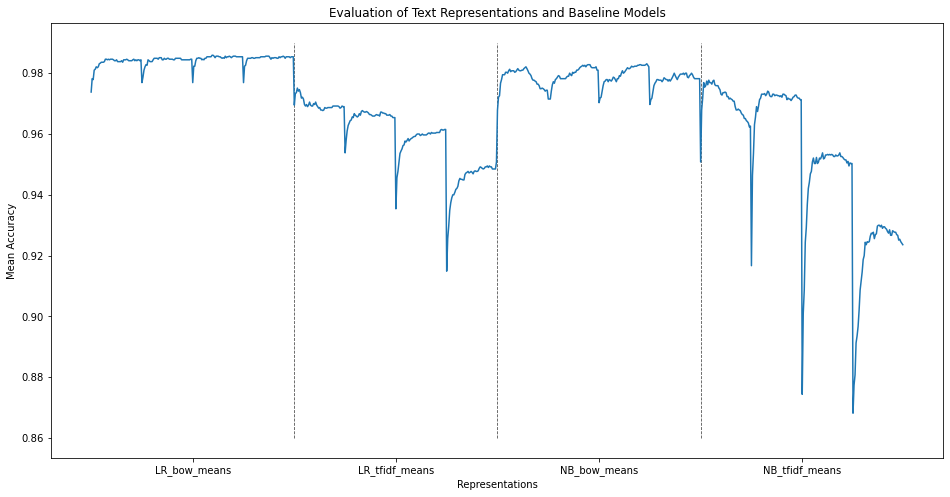

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 8))
plt.plot(tidy_df['mean_accuracy'])
plt.title('Evaluation of Text Representations and Baseline Models')
plt.ylabel('Mean Accuracy')
plt.xlabel('Representations')
plt.vlines(x=[200,400,600], ymin=.86, ymax=.99, colors='k', linewidth=.8, linestyle='dashed', alpha=.7)
plt.xticks(np.arange(100, 900, 200), list(np.unique(tidy_df['representation'])))
plt.show()

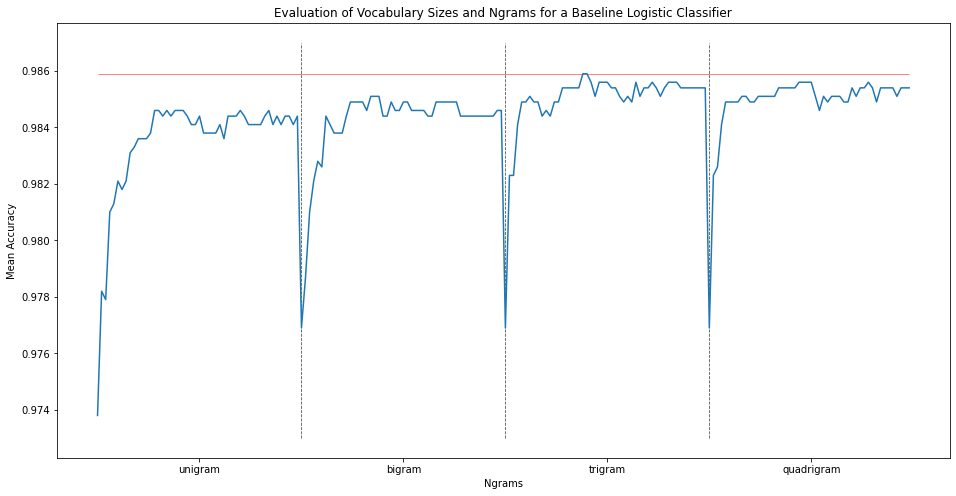

In [22]:
# subset to Logistic Regression on Bag-of-Nwords
LR_bow = tidy_df[tidy_df['representation']=="LR_bow_means"].copy()

plt.figure(figsize=(16, 8))
plt.plot(LR_bow['mean_accuracy'])
plt.title('Evaluation of Vocabulary Sizes and Ngrams for a Baseline Logistic Classifier')
plt.ylabel('Mean Accuracy')
plt.xlabel('Ngrams')
plt.vlines(x=[50,100,150], ymin=.973, ymax=.987, colors='k', linewidth=.8, linestyle='dashed', alpha=.7)
plt.hlines(y=np.unique(LR_bow['mean_accuracy'][LR_bow['mean_accuracy']==max(LR_bow['mean_accuracy'])])[0],
           xmin=0, xmax=199, colors='r', linewidth=.7, linestyle='solid', alpha=.7)
plt.xticks([25,75,125,175], ['unigram','bigram','trigram','quadrigram'])
plt.show()

In [23]:
# max mean accuracy plateau
LR_bow[LR_bow['mean_accuracy']==max(LR_bow['mean_accuracy'])]

,representation,ngram,vocab_size,mean_accuracy
119,LR_bow_means,3,2000,0.9859
120,LR_bow_means,3,2100,0.9859


In [24]:
mins, secs = divmod(time.time() - start_time, 60)
print(f'Time elapsed: {mins:0.0f} m {secs:0.0f} s')

Time elapsed: 24 m 16 s


---